In [58]:
using MLDatasets
using  Distances,SpectralClustering, Plots, Clustering
using Munkres
using Statistics
using MLBase

┌ Info: Precompiling MLBase [f0e99cf1-93fa-52ec-9ecc-5026115318e0]
└ @ Base loading.jl:1342
┌ Warning: Module Reexport with build ID 11409468608635 is missing from the cache.
│ This may mean Reexport [189a3867-3050-52da-a836-e630ba90ab69] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1030
┌ Info: Skipping precompilation since __precompile__(false). Importing MLBase [f0e99cf1-93fa-52ec-9ecc-5026115318e0].
└ @ Base loading.jl:1047


In [62]:
function make_cost_matrix(labels, classes)
    
    uc1 = sort(unique(labels))
    uc2 = sort(unique(classes))
    l1 = length(uc1)
    l2 = length(uc2)
    

    m = ones(l1, l2)
    for i=1:l1
        it_i = findall(labels .== uc1[i])
        for j=1:l2
            it_j = findall(classes .== uc2[j])
            m_ij =  intersect(it_j, it_i)
            m[i,j] =  -length(m_ij)
        end
    end
    return m
end
function relabel(predicted::Vector{<:Integer},ground_truth::Vector{<:Integer})
    s = make_cost_matrix(predicted, ground_truth)
    predicted_1 = copy(predicted)
    for (source, target) in enumerate(munkres(s))
        predicted_1[predicted.==source] .= target
    end
    return predicted_1
end

relabel (generic function with 1 method)

## Load data

In [68]:
train_x, train_y = MNIST.traindata()
train_y .+= 1
N = 10000
train_x = float.(reshape(train_x, (28*28, 60000)))
train_x = train_x[:, begin:N];
train_y = train_y[begin:N];

## Build the graph

In [99]:
knnconfig = KNNNeighborhood(train_x, 50)
function weight(i::Integer, neigh, v, m)
    return exp.(-Distances.colwise(SqEuclidean(), m, v) / 100)
end

graph = create(knnconfig, weight, train_x);
knnconfig = nothing

## Clusterize

In [100]:
pred_clustering_1 = clusterize(NgLaplacian(10), KMeansClusterizer(10), graph)
pred_clustering_1 = relabel(pred_clustering_1.assignments, train_y);

In [101]:
C = confusmat(10, train_y, pred_clustering_1)

10×10 Matrix{Int64}:
 954     1    3    3    4    7   27    0    2    0
   0  1118    2    1    1    0    0    1    1    3
   9   138  774   17   10    8    6   14    8    7
   3    31    5  896   18   24    5   16   28    6
   0    35    2    0  517    2    8    1    0  415
   6    11    1  355   29  429   24    0    7    1
   9    15    0    4    5   13  968    0    0    0
   0    47    2    0  101    4    0  855    0   61
   7    52    5  206   18   19   16    3  575   43
   3     7    2   18  470    1    3   18    1  455

In [146]:
correctrate(train_y, pred_clustering_1)

0.7541

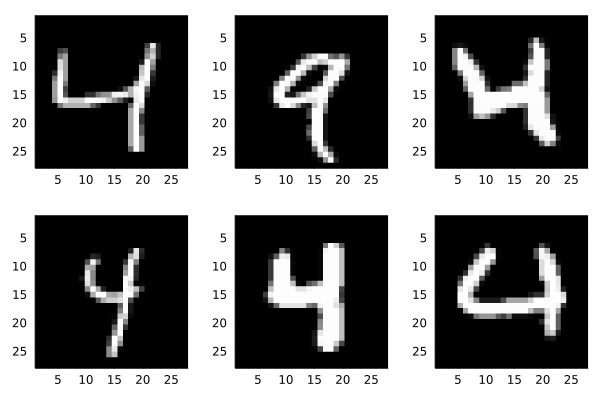

In [147]:
pred = findall(pred_clustering_1 .== (4 + 1))
plt = nothing
images = [plot(Gray.(reshape(train_x[:,pred[i]], 28, 28)')) for i=1:6]
plot(images...)

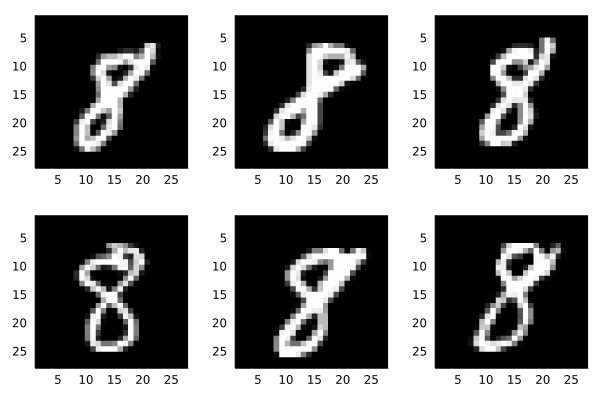

In [149]:
pred = findall(pred_clustering_1 .== (8 + 1))
plt = nothing
images = [plot(Gray.(reshape(train_x[:,pred[i]], 28, 28)')) for i=1:6]
plot(images...)